## 1. 필요 모듈 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 

## 2. 데이터 불러오기

In [23]:
_path_2019 = os.path.join('../data', '2019년 서울 아파트 실거래가.csv')
_path_2021 = os.path.join('../data', '2021년 서울 아파트 실거래가.csv')
apart_2021_yesna = os.path.join('../data', '2021년 서울 아파트 실거래가.csv')

## 2-1. 데이터 전처리

In [24]:
apart_2019 = pd.read_csv(_path_2019, encoding="cp949").dropna(how='any')
apart_2021 = pd.read_csv(_path_2021, encoding="cp949").dropna(how='any')
apart_2021_yesna = pd.read_csv(apart_2021_yesna, encoding="cp949")
temp_contract_date = apart_2021['계약년월']
apart_2019['거래금액'] = apart_2019['거래금액'].apply(lambda x : ''.join(x.split(',')))
apart_2021['거래금액(만원)'] = apart_2021['거래금액(만원)'].apply(lambda x : ''.join(x.split(',')))
apart_2019['거래금액'] = apart_2019['거래금액'].astype('int64')
apart_2021['거래금액(만원)']= apart_2021['거래금액(만원)'].astype('int64')
apart_2019['계약년월'] = (apart_2019['거래년도'].astype('str')+'-'+apart_2019['거래월'].astype('str')+'-' + apart_2019['거래일자'].astype('str')).astype('datetime64')
apart_2021['계약년월'] = apart_2021['계약년월'].astype('str').apply(lambda x: str(x[:4]) + '-'+str(x[4:])).astype('datetime64')
apart_2019['법정동'] = apart_2019['법정동'].apply(lambda x: ''.join(x.split()))
apart_2021['동']  = apart_2021.loc[apart_2021['해제사유발생일'].notnull(), '시군구'].apply(lambda x : x.split()[-1])
apart_2021_yesna['구']  = apart_2021_yesna['시군구'].apply(lambda x : x.split()[-2])

In [4]:
#영우의 PR
#2번째 PR
#3번째 PR
#4번째 PR

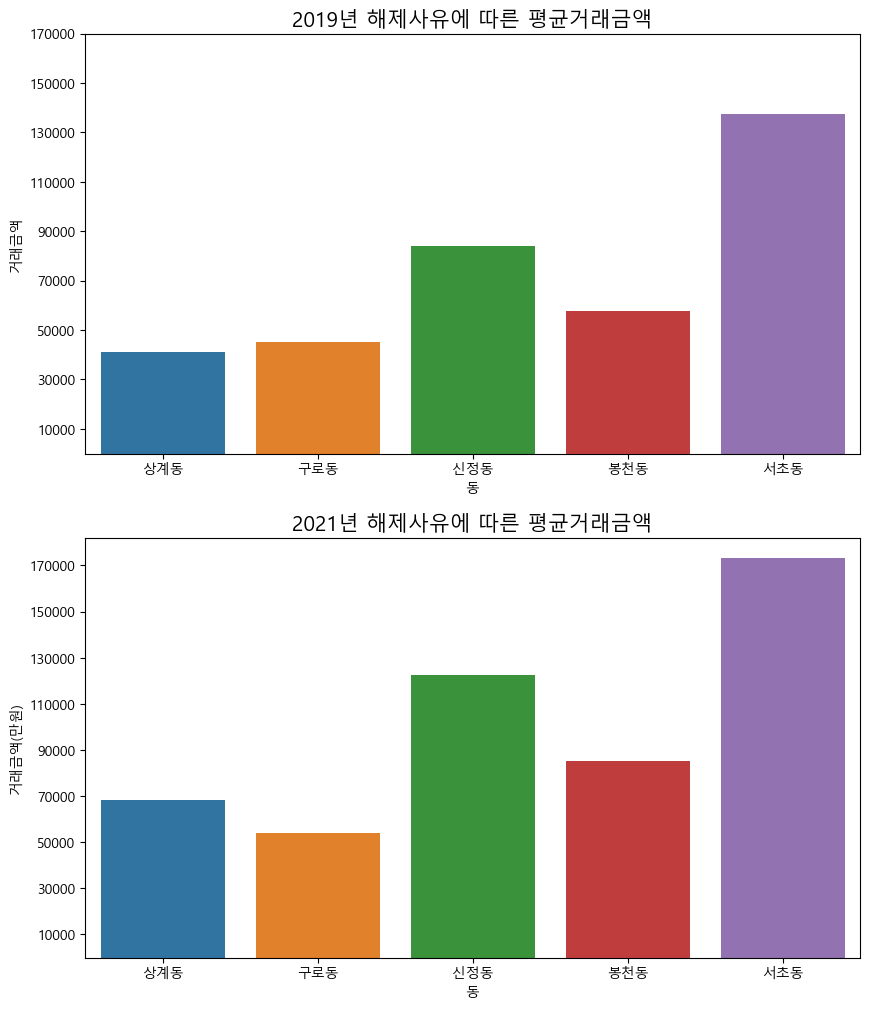

In [5]:
plt.figure(figsize=(10,12))
n = 2

h_2019_con = apart_2021.groupby('동')[['해제사유발생일']].agg('count').sort_values(by='해제사유발생일',ascending=False).head()
h_2021_con = apart_2021.groupby('동')[['해제사유발생일', '거래금액(만원)']].agg({'해제사유발생일':'count', '거래금액(만원)':'mean'}).sort_values(by='해제사유발생일',ascending=False).head()

h_2019_con = apart_2021.groupby('동')[['해제사유발생일']].agg('count').sort_values(by='해제사유발생일',ascending=False).head()
temp = h_2019_con.reset_index()['동']
k = apart_2019.groupby('법정동')[['거래금액']].mean().reset_index()
k2 = pd.merge(k, temp,left_on='법정동', right_on='동', how='right')

plt.subplot(n,1,1)
sns.barplot(x = k2['동'], y =k2['거래금액']).set_title('2019년 해제사유에 따른 평균거래금액', fontsize=15)
plt.yticks(np.arange(10000, 180000, 20000))
plt.subplot(n,1,2)
sns.barplot(x = h_2021_con.index, y = h_2021_con['거래금액(만원)']).set_title('2021년 해제사유에 따른 평균거래금액', fontsize=15)
plt.yticks(np.arange(10000, 180000, 20000))
plt.show()

## 2-2 상계 구로 신정 봉천 서초 중에서 해제사유가 발생한 아파트 만의 거래 금액 변화

In [6]:
# 동이 상계 구로 신정 봉천 서초면 True
def find_add(a):
    add = ['상계동', '구로동', '신정동', '봉천동', '서초동']
    if a in add:
        return True
    return False

# 21년 : 상계 구로 신정 봉천 서초 중 해제사유가 발생한 아파트 조건
condition_21 = apart_2021['동'].apply(find_add) & apart_2021['해제사유발생일'].notnull()
data_21 = apart_2021[condition_21][['동', '단지명', '거래금액(만원)']]

# 19년 : 상계 구로 신정 봉천 서초 중 21년 해제사유가 발생한 아파트
condition_19 = apart_2019['법정동'].apply(find_add) & (apart_2019['아파트이름'].isin(data_21['단지명']))
data_19 = apart_2019[condition_19][['법정동', '아파트이름','거래금액']]
change = data_21.groupby('동')['거래금액(만원)'].mean() - data_19.groupby('법정동')['거래금액'].mean()
# change = data_21.groupby('단지명')['거래금액(만원)'].mean() - data_19.groupby('아파트이름')['거래금액'].mean()
change.dropna(inplace=True)

change

동
구로동    -1930.944423
봉천동    24267.335047
상계동    27866.139779
서초동    27113.782051
신정동    23304.655559
dtype: float64

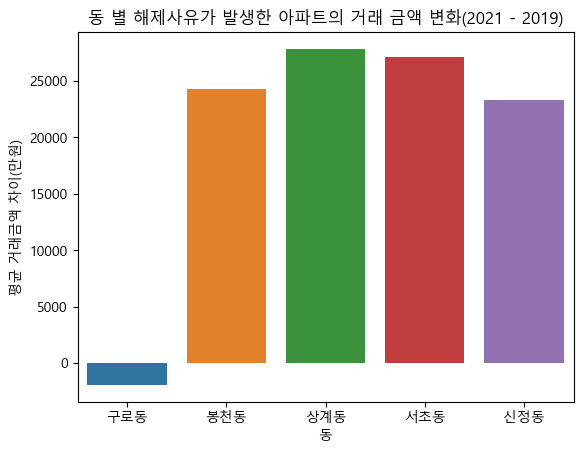

In [7]:
plt.yticks(np.arange(-20000, 30000, 5000))
plt.xlabel('동')
plt.ylabel('평균 거래금액 차이(만원)')
plt.title('동 별 해제사유가 발생한 아파트의 거래 금액 변화(2021 - 2019)')
sns.barplot(x=change.index, y=change.values)
plt.show()

## 3. 데이터 개요 확인

In [8]:
display(apart_2019.describe(), apart_2019.info())
display("-------------------------------------------------------------")
display(apart_2021.describe(), apart_2021.info())
display(apart_2019.corr(), apart_2021.corr())
display(apart_2019.head(), apart_2021.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68864 entries, 0 to 68863
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   건축년도    68864 non-null  int64         
 1   거래년도    68864 non-null  int64         
 2   거래월     68864 non-null  int64         
 3   거래일자    68864 non-null  int64         
 4   법정동     68864 non-null  object        
 5   거래금액    68864 non-null  int64         
 6   아파트이름   68864 non-null  object        
 7   전용면적    68864 non-null  float64       
 8   지역코드    68864 non-null  int64         
 9   층       68864 non-null  int64         
 10  지번      68864 non-null  object        
 11  계약년월    68864 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 6.3+ MB


,건축년도,거래년도,거래월,거래일자,거래금액,전용면적,지역코드,층
count,68864.000000,68864.0,68864.000000,68864.000000,68864.000000,68864.000000,68864.000000,68864.000000
mean,2000.296207,2019.0,7.997749,15.988731,81934.499651,77.847354,11461.217690,9.352492
std,9.961035,0.0,2.799286,8.830749,57889.552093,30.613276,178.251996,6.209369
min,1961.000000,2019.0,1.000000,1.000000,5400.000000,10.020000,11110.000000,-2.000000
25%,1993.000000,2019.0,6.000000,8.000000,44800.000000,59.750000,11320.000000,5.000000
50%,2001.000000,2019.0,8.000000,16.000000,66600.000000,83.320000,11470.000000,8.000000
75%,2007.000000,2019.0,10.000000,24.000000,99000.000000,84.970000,11620.000000,13.000000
max,2019.000000,2019.0,12.000000,31.000000,840000.000000,273.820000,11740.000000,67.000000


None

'-------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1360 entries, 6 to 43313
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   시군구       1360 non-null   object        
 1   번지        1360 non-null   object        
 2   본번        1360 non-null   float64       
 3   부번        1360 non-null   float64       
 4   단지명       1360 non-null   object        
 5   전용면적(㎡)   1360 non-null   float64       
 6   계약년월      1360 non-null   datetime64[ns]
 7   계약일       1360 non-null   int64         
 8   거래금액(만원)  1360 non-null   int64         
 9   층         1360 non-null   int64         
 10  건축년도      1360 non-null   int64         
 11  도로명       1360 non-null   object        
 12  해제사유발생일   1360 non-null   float64       
 13  거래유형      1360 non-null   object        
 14  중개사소재지    1360 non-null   object        
 15  동         1360 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(7)
memor

,본번,부번,전용면적(㎡),계약일,거래금액(만원),층,건축년도,해제사유발생일
count,1360.000000,1360.000000,1360.000000,1360.000000,1360.000000,1360.000000,1360.000000,1.360000e+03
mean,601.735294,10.775735,80.820937,15.021324,118538.385294,9.512500,2001.903676,2.021170e+07
std,553.788888,62.903588,38.394256,8.661842,89640.031244,6.927342,11.161481,2.921718e+03
min,1.000000,0.000000,12.230000,1.000000,9500.000000,-3.000000,1968.000000,2.021011e+07
25%,209.750000,0.000000,59.580000,8.000000,64225.000000,4.000000,1995.000000,2.021050e+07
50%,506.000000,0.000000,84.231050,15.000000,95500.000000,8.000000,2002.000000,2.021073e+07
75%,799.250000,1.000000,84.990000,22.250000,145000.000000,13.000000,2011.000000,2.021110e+07
max,4955.000000,922.000000,267.100900,31.000000,850000.000000,61.000000,2021.000000,2.022040e+07


None

,건축년도,거래년도,거래월,거래일자,거래금액,전용면적,지역코드,층
건축년도,1.000000,NaN,0.040245,0.006752,0.006478,-0.013346,-0.068236,0.197032
거래년도,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
거래월,0.040245,NaN,1.000000,-0.084139,0.030910,0.000877,-0.021972,0.006543
거래일자,0.006752,NaN,-0.084139,1.000000,0.000560,0.000479,0.009645,-0.001153
거래금액,0.006478,NaN,0.030910,0.000560,1.000000,0.622827,0.305474,0.156891
전용면적,-0.013346,NaN,0.000877,0.000479,0.622827,1.000000,0.097926,0.104046
지역코드,-0.068236,NaN,-0.021972,0.009645,0.305474,0.097926,1.000000,0.019439
층,0.197032,NaN,0.006543,-0.001153,0.156891,0.104046,0.019439,1.000000


,본번,부번,전용면적(㎡),계약일,거래금액(만원),층,건축년도,해제사유발생일
본번,1.000000,-0.035617,0.025149,-0.000581,-0.003706,0.069372,0.162914,0.053170
부번,-0.035617,1.000000,0.133793,0.005838,0.187489,0.062943,0.047990,-0.020273
전용면적(㎡),0.025149,0.133793,1.000000,-0.055815,0.667798,0.173927,-0.070925,0.037179
계약일,-0.000581,0.005838,-0.055815,1.000000,-0.081813,-0.011820,-0.010033,0.058345
거래금액(만원),-0.003706,0.187489,0.667798,-0.081813,1.000000,0.244713,-0.015254,0.052339
층,0.069372,0.062943,0.173927,-0.011820,0.244713,1.000000,0.189900,0.049938
건축년도,0.162914,0.047990,-0.070925,-0.010033,-0.015254,0.189900,1.000000,0.075008
해제사유발생일,0.053170,-0.020273,0.037179,0.058345,0.052339,0.049938,0.075008,1.000000


,건축년도,거래년도,거래월,거래일자,법정동,거래금액,아파트이름,전용면적,지역코드,층,지번,계약년월
0,2008,2019,1,7,사직동,105000,광화문풍림스페이스본(101동~105동),97.61,11110,10,9,2019-01-07
1,2008,2019,1,11,사직동,162000,광화문풍림스페이스본(106동),163.33,11110,11,9-1,2019-01-11
2,2008,2019,1,19,사직동,119000,광화문풍림스페이스본(101동~105동),131.44,11110,13,9,2019-01-19
3,2008,2019,1,30,사직동,119000,광화문풍림스페이스본(101동~105동),147.31,11110,1,9,2019-01-30
4,2004,2019,1,25,내수동,160000,경희궁의아침4단지,150.48,11110,14,73,2019-01-25


,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,동
6,서울특별시 강남구 개포동,1282,1282.0,0.0,개포래미안포레스트,49.92,2021-05-01,22,180000,7,2020,개포로 264,20210526.0,-,-,개포동
7,서울특별시 강남구 개포동,1282,1282.0,0.0,개포래미안포레스트,59.92,2021-05-01,22,198500,18,2020,개포로 264,20210526.0,-,-,개포동
26,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,104.43,2021-01-01,5,220000,3,1984,개포로 307,20210201.0,-,-,개포동
29,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,104.43,2021-02-01,9,145000,6,1984,개포로 307,20210223.0,-,-,개포동
58,서울특별시 강남구 개포동,185,185.0,0.0,개포주공7단지,73.26,2021-01-01,30,235000,1,1983,개포로 516,20210426.0,-,-,개포동


## 4-1 2019년과 2021년도의 동별 거래금액의 평균, 최소, 최댓값

In [9]:
from cProfile import label


def split_address(x):
    dong = x.split()[-1]
    return dong
ap1_dong = apart_2021.loc[:, '시군구'].apply(split_address)


apart_2019_new = pd.DataFrame()
apart_2019_new['아파트이름'] = apart_2019['아파트이름'] 
apart_2019_new['동'] = apart_2019['법정동'].str.strip()
apart_2019_new['거래금액']=apart_2019['거래금액'] 
apart_2019_new['계약년월']=apart_2019['계약년월'] 


apart_2021_new = pd.DataFrame()
apart_2021_new['아파트이름'] = apart_2021['단지명']
apart_2021_new['동'] = ap1_dong
apart_2021_new['거래금액'] = apart_2021['거래금액(만원)']
apart_2021_new['계약년월'] = apart_2021['계약년월']


df19 = apart_2019_new.groupby('동')['거래금액'].agg(['mean', 'min', 'max']).reset_index()
df21 = apart_2021_new.groupby('동')['거래금액'].agg(['mean', 'min', 'max']).reset_index()
df = pd.merge(df19, df21,on='동',how='inner')
df['mean_dif'] = df['mean_y']-df['mean_x']
df['min_dif'] = df['min_y']-df['min_x']
df['max_dif'] = df['max_y']-df['max_x']
pd.set_option('display.max_rows', None)
df

,동,mean_x,min_x,max_x,mean_y,min_y,max_y,mean_dif,min_dif,max_dif
0,가락동,86998.792393,16000,190470,153377.777778,93000,260000,66378.985385,77000,69530
1,가산동,40847.113043,10500,64000,37225.000000,14800,63000,-3622.113043,4300,-1000
2,가양동,57006.531111,20000,130000,90625.000000,60000,137200,33618.468889,40000,7200
3,갈현동,35974.051724,12200,65000,71500.000000,68000,75000,35525.948276,55800,10000
4,개봉동,44975.365497,12850,81700,62800.000000,40900,103500,17824.634503,28050,21800
5,개포동,172408.725000,33000,338000,195733.333333,111000,303000,23324.608333,78000,-35000
6,거여동,62424.660584,30800,100000,125500.000000,93000,169500,63075.339416,62200,69500
7,고덕동,100689.982630,40000,160000,162233.333333,109000,400000,61543.350703,69000,240000
8,고척동,45349.498747,17000,87000,67100.000000,48500,81000,21750.501253,31500,-6000
9,공덕동,101972.058824,16500,215000,125200.000000,17000,175000,23227.941176,500,-40000


## 4-1 데이터 시각화 - 상관관계 분석 히트맵

In [10]:
Q3_2019 = apart_2019['거래금액'].quantile(0.75)
Q1_2019 = apart_2019['거래금액'].quantile(0.25)
IQR2019 = Q3_2019 - Q1_2019
lower_fence2019 = Q1_2019 - (IQR2019 * 1.5)   # 보다 작거나
upper_fence2019 = Q3_2019 + (IQR2019 * 1.5)   # 보다 큰 것
print(IQR2019, lower_fence2019, upper_fence2019)

Q3_2021 = apart_2021['거래금액(만원)'].quantile(0.75)
Q1_2021 = apart_2021['거래금액(만원)'].quantile(0.25)
IQR2021 = Q3_2021 - Q1_2021
lower_fence2021 = Q1_2021 - (IQR2021 * 1.5)   # 보다 작거나
upper_fence2021 = Q3_2021 + (IQR2021 * 1.5)   # 보다 큰 것
print(IQR2021, lower_fence2021, upper_fence2021)

54200.0 -36500.0 180300.0
80775.0 -56937.5 266162.5


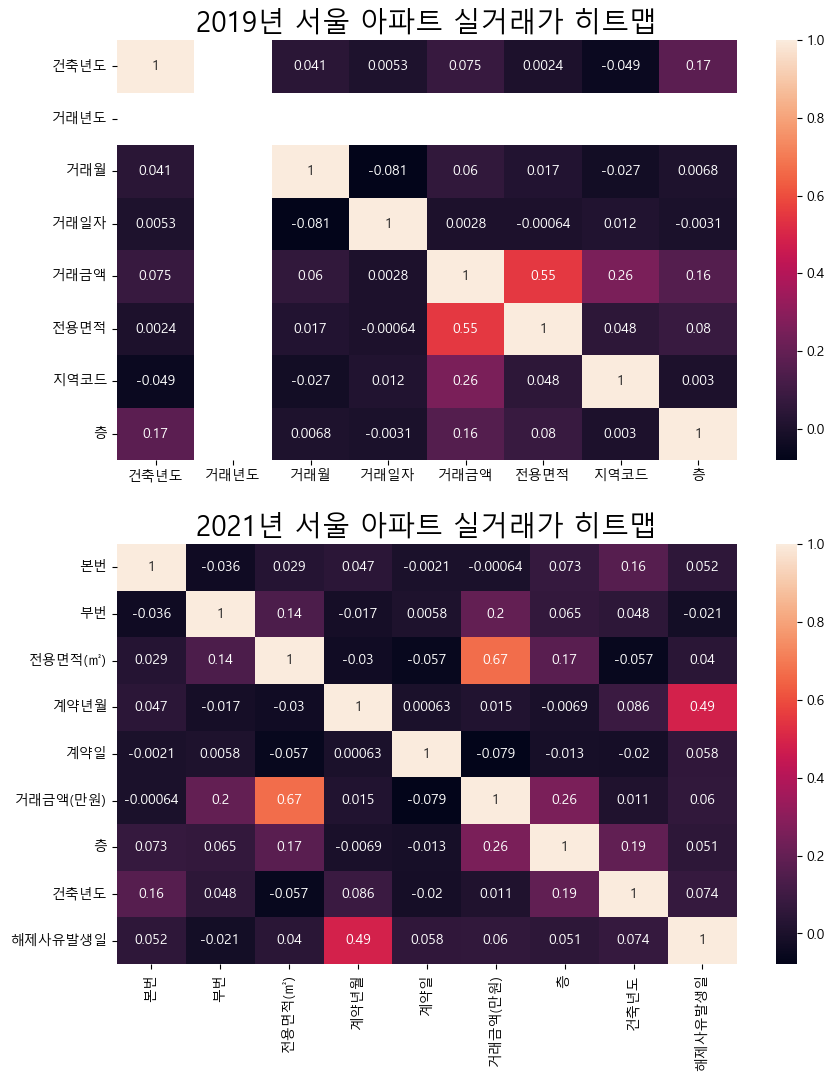

In [11]:
#outlier없는 히트맵
apart_2021['계약년월'] = temp_contract_date
con2019 = apart_2019['거래금액'] <= upper_fence2019
nooutlier_2019 = apart_2019.loc[con2019]

con2021 = apart_2021['거래금액(만원)'] <= upper_fence2021
nooutlier_2021 = apart_2021.loc[con2019]

plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
sns.heatmap(nooutlier_2019.corr(), annot=True).set_title('2019년 서울 아파트 실거래가 히트맵', fontsize=20)
plt.subplot(2,1,2)
sns.heatmap(nooutlier_2021.corr(), annot=True).set_title('2021년 서울 아파트 실거래가 히트맵', fontsize=20)
plt.show()

## 4-2. 데이터 시각화 - 거래금액에 따른 박스 플롯

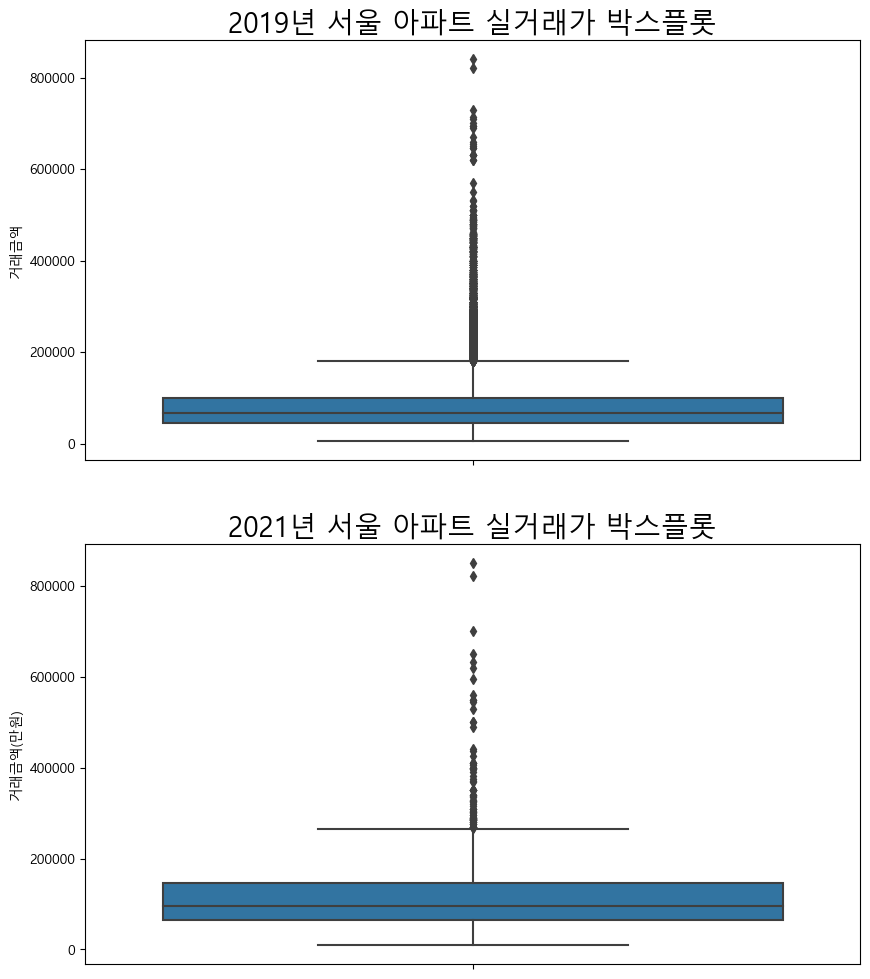

In [12]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
# display(sns.boxplot(x= '거래금액', y='전용면적', data=apart_2019))
sns.boxplot(y= '거래금액', data=apart_2019).set_title('2019년 서울 아파트 실거래가 박스플롯', fontsize=20)
plt.subplot(2,1,2)
# display(sns.boxplot(x= '거래금액(만원)', y='전용면적(㎡)', data=apart_2021))
sns.boxplot(y= '거래금액(만원)', data=apart_2021).set_title('2021년 서울 아파트 실거래가 박스플롯', fontsize=20)
plt.show()

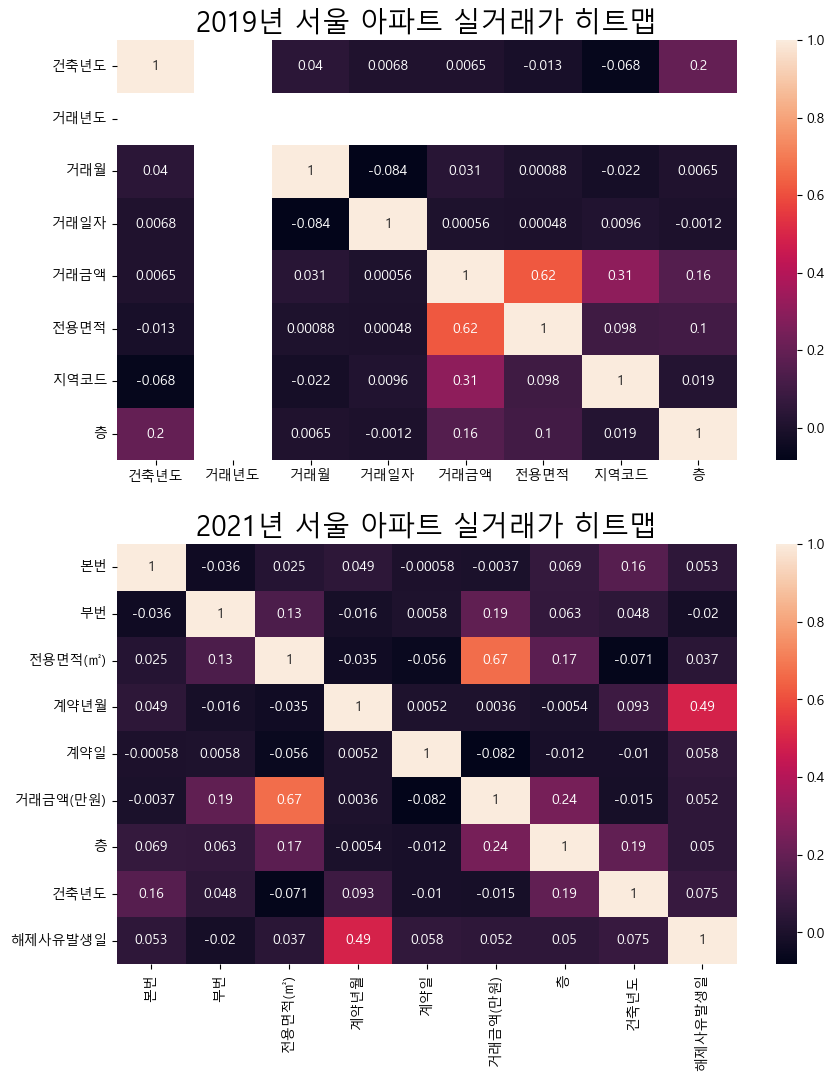

In [13]:
#outlier있는 히트맵
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
sns.heatmap(apart_2019.corr(), annot=True).set_title('2019년 서울 아파트 실거래가 히트맵', fontsize=20)
plt.subplot(2,1,2)
sns.heatmap(apart_2021.corr(), annot=True).set_title('2021년 서울 아파트 실거래가 히트맵', fontsize=20)
plt.show()
apart_2021['계약년월'] = apart_2021['계약년월'].astype('str').apply(lambda x: str(x[:4]) + '-'+str(x[4:])).astype('datetime64')

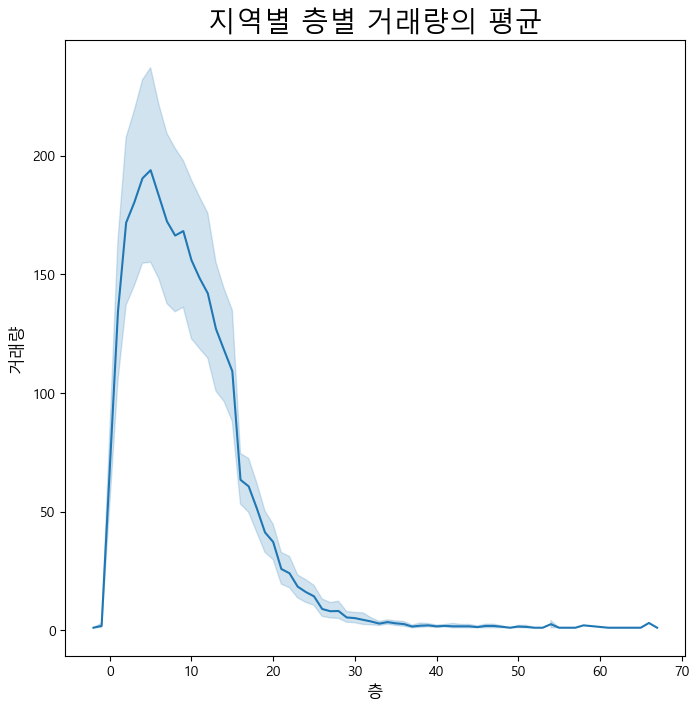

In [14]:
#지역별 층별 거래량의 평균
plt.figure(figsize=(8,8))
floor_count = pd.DataFrame(apart_2019.groupby(['지역코드'])['층'].value_counts()).rename(columns={'층': '거래량'})
sns.lineplot(data=floor_count, x='층', y='거래량')
plt.title('지역별 층별 거래량의 평균', fontsize=20)
plt.xlabel('층', fontsize=12)
plt.ylabel('거래량', fontsize=12)
plt.show()

,층,거래량
0,-2~4,21788
1,5~11,33257
2,12~18,17814
3,19~25,4488
4,26~32,846
5,33~39,218
6,40~46,70
7,47~53,32
8,54~60,13
9,61~67,8


<AxesSubplot:xlabel='층', ylabel='거래량'>

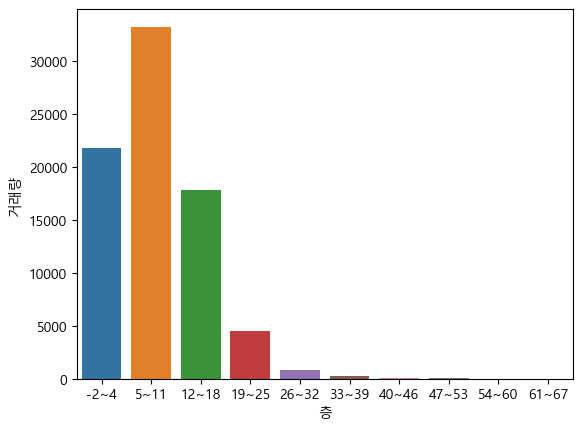

In [15]:
#지역별 7개층당 거래량
floor_list = []
for i in list(set(apart_2019['지역코드'])):
    floor_count_hist = pd.DataFrame(np.array(floor_count.reset_index()).reshape(910,3)).rename(columns={0: '지역코드', 1: '층', 2: '거래량'})
    con = floor_count_hist['지역코드'] == i
    floor_count_hist.loc[con]
    temp_floor = pd.DataFrame(np.array(floor_count.reset_index()).reshape(910,3)).rename(columns={0: '지역코드', 1: '층', 2: '거래량'})
    con = temp_floor['지역코드'] == i
    temp_floor = temp_floor.loc[con]
    for i in range(10):
        
        con2 = (temp_floor['층'] >= i*7-2) & (temp_floor['층'] < i*7+6)
        i = temp_floor.loc[con2]
        
        floor_list.append(i['거래량'].sum())
temp = pd.DataFrame(pd.DataFrame(np.array(floor_list).reshape(25,10)).sum()).rename(columns={0: '거래량'})
for i in range(10):
    temp = temp.rename(index={i: f'{i*7-2}~{i*7+4}'})
temp = temp.reset_index().rename(columns={'index': '층'})
display(temp)
sns.barplot(data=temp, x='층', y='거래량')

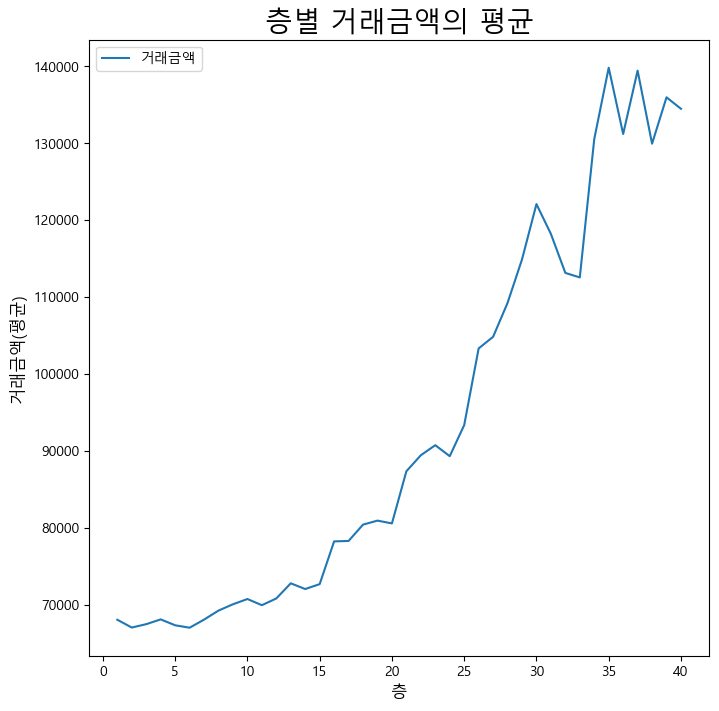

In [16]:
#1층부터 30층까지 층별 거래금액의 평균
plt.figure(figsize=(8,8))
con_floor = (nooutlier_2019['층'] <= 40) & (1 <= nooutlier_2019['층'])
floor_1_to_30 = nooutlier_2019.loc[con_floor]
floor_1_to_30_mean = pd.DataFrame(floor_1_to_30.groupby(['층'])['거래금액'].mean())
sns.lineplot(data=floor_1_to_30_mean)
plt.title('층별 거래금액의 평균', fontsize=20)
plt.xlabel('층', fontsize=12)
plt.ylabel('거래금액(평균)', fontsize=12)
plt.show()


,층,거래량
0,-2~4,21788
1,5~11,33257
2,12~18,17814
3,19~25,4488
4,26~32,846
5,33~39,218
6,40~46,70
7,47~53,32
8,54~60,13
9,61~67,8


<AxesSubplot:xlabel='층', ylabel='거래량'>

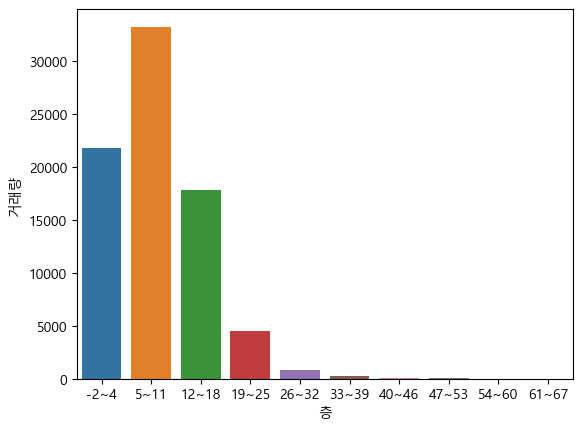

In [17]:
#지역별 7개층당 거래량
floor_list = []
for i in list(set(apart_2019['지역코드'])):
    floor_count_hist = pd.DataFrame(np.array(floor_count.reset_index()).reshape(910,3)).rename(columns={0: '지역코드', 1: '층', 2: '거래량'})
    con = floor_count_hist['지역코드'] == i
    floor_count_hist.loc[con]
    temp_floor = pd.DataFrame(np.array(floor_count.reset_index()).reshape(910,3)).rename(columns={0: '지역코드', 1: '층', 2: '거래량'})
    con = temp_floor['지역코드'] == i
    temp_floor = temp_floor.loc[con]
    for i in range(10):
        
        con2 = (temp_floor['층'] >= i*7-2) & (temp_floor['층'] < i*7+6)
        i = temp_floor.loc[con2]
        
        floor_list.append(i['거래량'].sum())
temp = pd.DataFrame(pd.DataFrame(np.array(floor_list).reshape(25,10)).sum()).rename(columns={0: '거래량'})
for i in range(10):
    temp = temp.rename(index={i: f'{i*7-2}~{i*7+4}'})
temp = temp.reset_index().rename(columns={'index': '층'})
display(temp)
sns.barplot(data=temp, x='층', y='거래량')